# Import Libraries

In [103]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load Alpaca Keys

In [104]:
load_dotenv()
ALPACA_API_KEY = os.getenv("APCA_API_KEY_ID")
ALPACA_SECRET_KEY = os.getenv("APCA_API_SECRET_KEY")
client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)

# get_stock_data() — Fetch from Alpaca API
# adjust_for_stock_split() — Normalize pre-split prices

In [105]:
def get_stock_data(symbol: str, start_date: str, end_date: str):
    """
    Fetch weekly stock OHLCV data for a symbol from Alpaca.
    """
    request_params = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=TimeFrame.Week,
        start=pd.to_datetime(start_date),
        end=pd.to_datetime(end_date)
    )
    
    bars = client.get_stock_bars(request_params).df
    df = bars[bars.index.get_level_values(0) == symbol].copy()
    df.index = df.index.droplevel(0)
    df.index = pd.to_datetime(df.index)
    
    return df



def adjust_for_stock_split(df, split_date, split_ratio):
    """
    Adjust historical stock OHLCV data to account for stock splits.
    
    Args:
        df: DataFrame with OHLCV data
        split_date: Date of the stock split (YYYY-MM-DD format or datetime)
        split_ratio: e.g., 10 for a 10:1 split
    """
    df_adjusted = df.copy()
    
    if isinstance(split_date, str):
        split_date = pd.to_datetime(split_date).tz_localize('UTC')
    
    pre_split_mask = df_adjusted.index < split_date
    
    if pre_split_mask.any():
        print(f"Adjusting {pre_split_mask.sum()} data points for {split_ratio}:1 stock split on {split_date.date()}")

        price_columns = ['open', 'high', 'low', 'close']
        for col in price_columns:
            if col in df_adjusted.columns:
                df_adjusted.loc[pre_split_mask, col] = df_adjusted.loc[pre_split_mask, col] / split_ratio
        
        if 'volume' in df_adjusted.columns:
            df_adjusted.loc[pre_split_mask, 'volume'] = df_adjusted.loc[pre_split_mask, 'volume'] * split_ratio
    
    return df_adjusted



df = get_stock_data("NVDA", "2022-01-01", "2025-07-21")
df = adjust_for_stock_split(df, split_date="2024-06-10", split_ratio=10)

Adjusting 127 data points for 10:1 stock split on 2024-06-10


# Add Technical Indicators (MACD, RSI, SMAs)

In [106]:
import ta

# Drop missing values just in case
df = df.dropna()

# Add MACD and Signal Line
df['MACD'] = ta.trend.macd(df['close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['close'])

# Add RSI
df['RSI'] = ta.momentum.rsi(df['close'])

# Add Simple Moving Averages
df['SMA5'] = ta.trend.sma_indicator(df['close'], window=5)
df['SMA20'] = ta.trend.sma_indicator(df['close'], window=20)
df['SMA50'] = ta.trend.sma_indicator(df['close'], window=50)

# Re-drop in case any indicators introduced NaNs at beginning
df = df.dropna().copy()

# Visualize Price, MACD, Volume

In [107]:
# Determine bar color based on price change
df['Color'] = np.where(df['close'] >= df['open'], 'green', 'red')
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.5, 0.25, 0.25],
    subplot_titles=("Candlestick with SMAs", "MACD", "Volume")
)

# Candlestick Chart
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='OHLC',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# SMAs overlay
fig.add_trace(go.Scatter(x=df.index, y=df['SMA5'], name='SMA 5', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA20'], name='SMA 20', line=dict(color='purple')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA50'], name='SMA 50', line=dict(color='blue')), row=1, col=1)

# MACD Line + Signal
fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['MACD_Signal'], name='MACD Signal', line=dict(color='red')), row=2, col=1)

# MACD Histogram
fig.add_trace(go.Bar(
    x=df.index,
    y=df['MACD_Hist'],
    name='MACD Histogram',
    marker_color=np.where(df['MACD_Hist'] >= 0, 'green', 'red'),
    showlegend=True
), row=2, col=1)

# Volume (green if up day, red if down)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['volume'],
    name='Volume',
    marker_color=df['Color'],
    showlegend=True
), row=3, col=1)

# Final layout
fig.update_layout(
    title='NVDA Weekly Stock Price, MACD, and Volume Analysis',
    xaxis_rangeslider_visible=False,
    template='plotly_white',
    height=900,
    margin=dict(t=40, b=40),
)

fig.show()


# Prepare Data for LSTM

In [108]:
def prepare_data(df, look_back=10):
    features = ['close', 'SMA5', 'SMA20', 'SMA50', 'MACD', 'MACD_Signal', 'RSI']
    df_clean = df.dropna().copy()

    # Add target column: 1 if next week's close > this week's close
    df_clean['Target'] = (df_clean['close'].shift(-1) > df_clean['close']).astype(int)

    # Drop final row (its target will be NaN after shift)
    df_clean = df_clean[:-1]

    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_clean[features])
    scaled_df = pd.DataFrame(scaled_features, index=df_clean.index, columns=features)

    # Store target separately
    y = df_clean['Target'].values

    # Create sequences
    X = []
    y_seq = []
    for i in range(look_back, len(scaled_df)):
        X.append(scaled_df.iloc[i - look_back:i].values)
        y_seq.append(y[i])

    X = np.array(X)
    y_seq = np.array(y_seq)

    # Split into train/test sets
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]

    print(f"Prepared data with {len(X_train)} training samples and {len(X_test)} test samples.")
    return X_train, X_test, y_train, y_test, scaler



X_train, X_test, y_train, y_test, scaler = prepare_data(df, look_back=10)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Prepared data with 100 training samples and 25 test samples.
Training data shape: (100, 10, 7)
Testing data shape: (25, 10, 7)


# Build LSTM Model

In [109]:
def create_model(input_shape):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=False,
                   kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model



input_shape = (X_train.shape[1], X_train.shape[2])  # (10, 7)
model = create_model(input_shape)
model.summary()

/Users/misbahsmac/Desktop/GitHub/NVDA-LSTM-predictor/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,521 (201.25 KB)

 Trainable params: 51,521 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [110]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4800 - loss: 0.8056 - val_accuracy: 0.3600 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6300 - loss: 0.7700 - val_accuracy: 0.3200 - val_loss: 0.8077 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6300 - loss: 0.7587 - val_accuracy: 0.2000 - val_loss: 0.8253 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6200 - loss: 0.7408 - val_accuracy: 0.3200 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6300 - loss: 0.7329 - val_accuracy: 0.3600 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6300 - loss: 0.7200 - val_accuracy: 0.3600 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.7128 - val_accuracy: 0.60

# Plot Training History

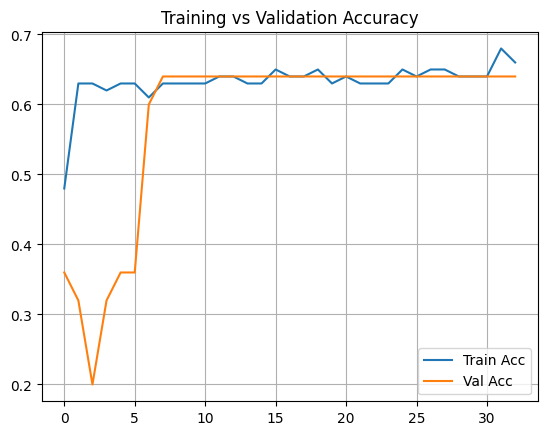

In [111]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate Model

In [112]:
# Evaluate on train set
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Calculate validation gap
val_gap = abs(train_acc - test_acc)

# Print results
print("Model Performance:")
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")
print(f"Validation Gap: {val_gap:.4f}")

Model Performance:
Train accuracy: 0.6500
Test accuracy:  0.6400
Validation Gap: 0.0100


# Predict Next Day Direction

In [113]:
# Get the last 10 weeks of data (normalized)
last_sequence = df[-10:].copy()

# Select and scale the same features used during training
features = ['close', 'SMA5', 'SMA20', 'SMA50', 'MACD', 'MACD_Signal', 'RSI']
last_scaled = scaler.transform(last_sequence[features])

# Reshape for LSTM: (1 sample, 10 timesteps, 7 features)
X_input = np.expand_dims(last_scaled, axis=0)

# Predict probability
prob = model.predict(X_input)[0][0]
direction = "UP" if prob >= 0.5 else "DOWN"

# Display result
print("Prediction for tomorrow:")
print(f"Probability of price increase: {prob * 100:.2f}%")
print(f"Predicted direction: {direction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Prediction for tomorrow:
Probability of price increase: 61.39%
Predicted direction: UP
